## Compute the azimuth and elevation phase maps

1. Compute the fft of each stimulation
2. To correct for phase delays subtract the phase of stimuli moving in opposite directions
3. Plot stimuli phase as time.

In [10]:
from numpy.fft import fft
from os.path import join as pjoin
from skimage import measure
from scipy.ndimage import median_filter
from tifffile import imwrite
from wfield import im_fftphase_hsv, reconstruct, visual_sign_map

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

%matplotlib inline


In [11]:
### 路径和刺激重复次数。（本代码对应的是每个方向连续重复10次再下一个方向）
# path_wfield = '/home/wrx/Data_WF/WF_WRX/P42/20240813_DOM/2_Retinotopy/process/20240813-104738-wfield'
# path_wfield = '/home/wrx/Data_WF/WF_WRX/P42/20240726/saline/1_Retinotopy/process/20240726-154732-wfield'
# path_wfield = '/home/wrx/Data_WF/WF_WRX/P42/20240726/DOM/1_Retinotopy/process/20240726-170926-wfield'
# path_wfield = '/home/wrx/Data_WF/WF_WRX/P42/20240808_saline/2_Retinotopy/process/20240808-110402-wfield'
# path_wfield = '/home/wrx/Data_WF/WF_WRX/P42/20240812_avertin/2_Retinotopy/process/20240812-134857-wfield'
# path_wfield = '/home/wrx/Data_WF/WF_WRX/P42/20240813_DOM/2_Retinotopy/process/20240813-104738-wfield'
# path_wfield = '/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/2_Retinotopy/process/20240826-142921-wfield'
# path_wfield = '/home/wrx/Data_WF/WF_WRX/Q38/20240826_DOM/2_Retinotopy/process/20240826-160734-wfield'
path_wfield = '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/2_Retinotopy/process/20240829-163749-wfield'
# path_wfield = '/home/wrx/Data_WF/WF_WRX/Q39/20240829_DOM/2_Retinotopy/process/20240829-185241-wfield'

# path_wfield = '/home/wrx/Data_WF/WF_VC_liuzhaoxi/24.07.18_P73/retinotopy/process/20240718-161348-wfield'
nrepeats = 10
post_trial = 3   # 刺激消失后多取几秒

path_out = pjoin(path_wfield, '..', os.path.basename(path_wfield)[:16]+'retinotopy')
os.makedirs(path_out, exist_ok=True)


In [12]:
### load data
trials = pd.read_csv(pjoin(path_wfield, "trials.csv"), header=None, dtype=int).values
nframes_el = min(trials[:20, 3]) + post_trial*10
nframes_az = min(trials[20:40, 3]) + post_trial*10
# nframes_el = min(trials[:20, 3])
# nframes_az = min(trials[20:40, 3])
# nframes_el = 130
# nframes_az = 163
U = np.load(pjoin(path_wfield, 'U.npy'))
SVTcorr = np.load(pjoin(path_wfield, 'SVTcorr.npy'))
# SVTcorr = np.load(pjoin(path_wfield, 'SVT.npy'))
nSVD = SVTcorr.shape[0]

### extract trial-data for 4 direction stimuli respectively.
def _sort_frames(nframes, *ntrials):
    avg = np.empty((nSVD, 0, nframes))
    raw = np.empty((nSVD, 0))
    for i in ntrials:
        avg = np.concatenate((avg, SVTcorr[:, trials[i, 1]:trials[i, 1] + nframes].reshape(nSVD, 1, nframes)), axis=1)
        raw = np.concatenate((raw, SVTcorr[:, trials[i, 1]:trials[i, 1] + nframes]), axis=1)
    avg = np.mean(avg, axis=1)
    return avg, raw

avg_up, raw_up = _sort_frames(nframes_el, *range(nrepeats * 0, nrepeats * 1))
avg_down, raw_down = _sort_frames(nframes_el, *range(nrepeats * 1, nrepeats * 2))
avg_left, raw_left = _sort_frames(nframes_az, *range(nrepeats * 2, nrepeats * 3))
avg_right, raw_right = _sort_frames(nframes_az, *range(nrepeats * 3, nrepeats * 4))


In [13]:
### export trial-average tif

imwrite(pjoin(path_out, 'avg_up.tif'), reconstruct(U, avg_up).astype('float32'), imagej=True)
imwrite(pjoin(path_out, 'avg_down.tif'), reconstruct(U, avg_down).astype('float32'), imagej=True)
imwrite(pjoin(path_out, 'avg_left.tif'), reconstruct(U, avg_left).astype('float32'), imagej=True)
imwrite(pjoin(path_out, 'avg_right.tif'), reconstruct(U, avg_right).astype('float32'), imagej=True)
print('Finish exporting trial-average tif')


Finish exporting trial-average tif


In [14]:
### export rep tif

imwrite(pjoin(path_out, 'rep_up.tif'), reconstruct(U, raw_up).astype('float32'), imagej=True)
imwrite(pjoin(path_out, 'rep_down.tif'), reconstruct(U, raw_down).astype('float32'), imagej=True)
imwrite(pjoin(path_out, 'rep_left.tif'), reconstruct(U, raw_left).astype('float32'), imagej=True)
imwrite(pjoin(path_out, 'rep_right.tif'), reconstruct(U, raw_right).astype('float32'), imagej=True)
print('Finish exporting rep tif')


Finish exporting rep tif


In [1]:
### computes fft in SVD space
component = 10
# from scipy.ndimage import gaussian_filter,median_filter
# mov = runpar(median_filter, U.transpose((2, 0, 1)), size=5)
# U1 = np.stack(mov).transpose((1, 2, 0)).astype(np.float32)
up = reconstruct(U, fft(raw_up.T, axis=0)[component])
down = reconstruct(U, fft(raw_down.T, axis=0)[component])
left = reconstruct(U, fft(raw_left.T, axis=0)[component])
right = reconstruct(U, fft(raw_right.T, axis=0)[component])
phase_el = -1. * (np.angle(up) - np.angle(down))
# phase_el = (phase_el + np.pi) % (2 * np.pi)
phase_el = (phase_el) % (2 * np.pi)
mag_el = (np.abs(up + down) * 2.)

phase_az = -1. * (np.angle(left) - np.angle(right))
# phase_az = (phase_az + np.pi) % (2 * np.pi)
phase_az = (phase_az) % (2 * np.pi)
mag_az = (np.abs(left + right) * 2.)


NameError: name 'reconstruct' is not defined

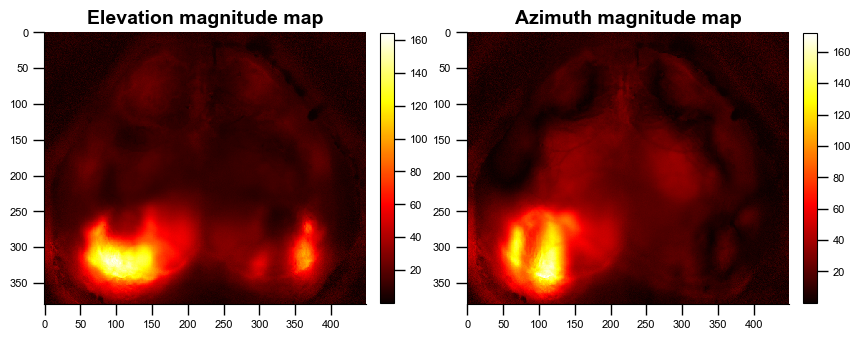

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
cb = axs[0].imshow(mag_el, cmap='hot')
fig.colorbar(cb, ax=axs[0], fraction=0.046, pad=0.04, shrink=0.7)
axs[0].set_title('Elevation magnitude map')

cb = axs[1].imshow(mag_az, cmap='hot')
fig.colorbar(cb, ax=axs[1], fraction=0.046, pad=0.04, shrink=0.7)
axs[1].set_title('Azimuth magnitude map')
plt.show()

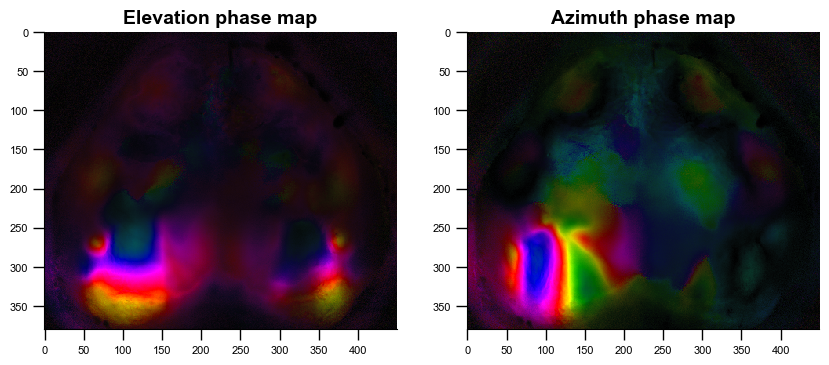

In [17]:
### plot phase maps

# fig = plt.figure(figsize=[10, 5])
fig, axs = plt.subplots(1, 2, figsize=[10, 7])
# fig.add_subplot(1, 2, 1)
cb = axs[0].imshow(im_fftphase_hsv([mag_el, phase_el], return_hsv=False))
# plt.axis('off')
# fig.colorbar(cb, ax=axs[0], location='bottom', shrink=0.8)
axs[0].set_title('Elevation phase map')

axs[1].imshow(im_fftphase_hsv([mag_az, phase_az], return_hsv=False))
# plt.axis('off')
axs[1].set_title('Azimuth phase map')
fig.set_facecolor('white')
# plt.savefig(pjoin(path_out, 'el_az_unfiltered.png'))
plt.show()

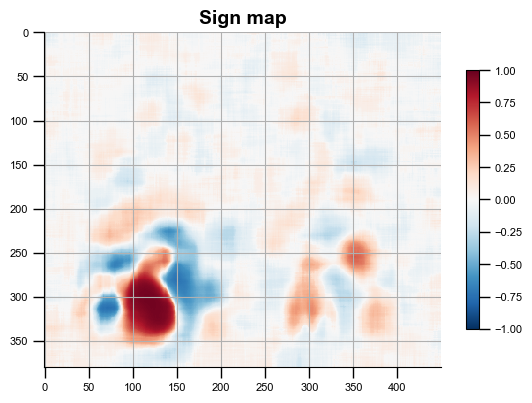

In [18]:
### plot sign maps

sign_map = median_filter(visual_sign_map(phase_az, phase_el), 33)
np.save(pjoin(path_out, 'sign_map.npy'), sign_map)
fig = plt.figure()
plt.imshow(sign_map,
           cmap='RdBu_r', clim=[-1, 1])
plt.grid()
plt.colorbar(shrink=0.7)
x, y = 153, 320
# plt.plot(x, y, 'o', color='black', markersize=5)
# plt.axis('off')
plt.title('Sign map')
fig.set_facecolor('white')
# plt.savefig(pjoin(path_out, 'signmap.png'))
plt.show()


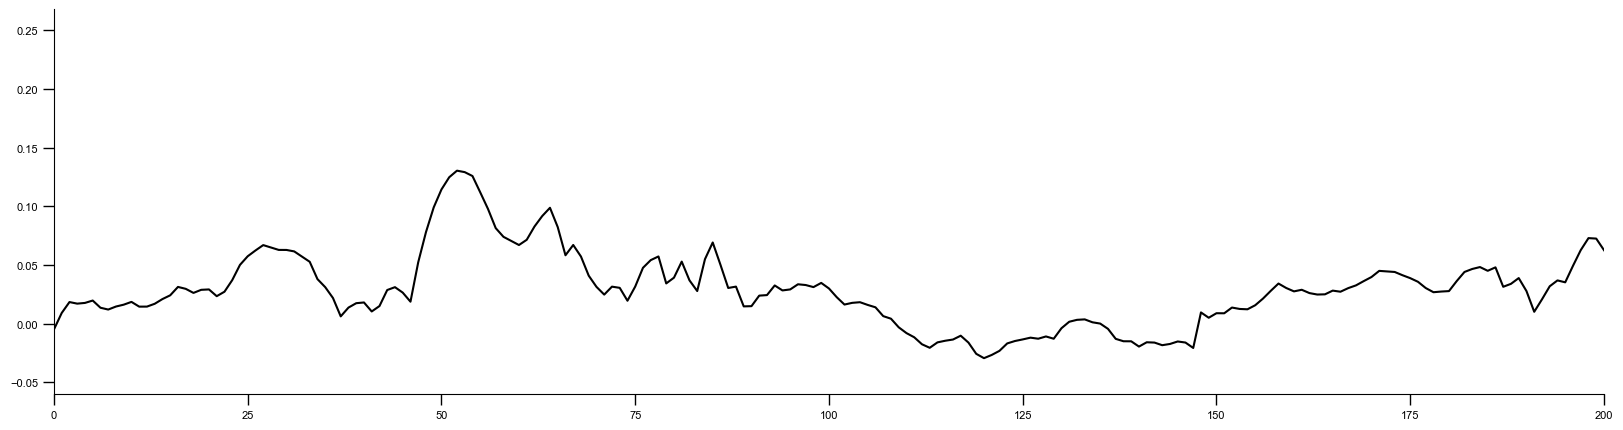

In [13]:
trace1 = mov_up[:, y, x]
# trace2 = mov_up[:, x, y]
fig, ax = plt.subplots(figsize=[20, 5])
ax.plot(trace1, label='1')
# ax.plot(trace2, label='2')
ax.set_xlim([0, 200])
plt.show()

In [12]:
from wfield.imutils import phasemap_to_visual_degrees


In [20]:
phase_up_degree = phasemap_to_visual_degrees(np.angle(up),-23.2, 73.2)
phase_left_degree = phasemap_to_visual_degrees(np.angle(left),-18.2, 108.2)
phase_down_degree = phasemap_to_visual_degrees(np.angle(down),73.2, -23.2)
phase_right_degree = phasemap_to_visual_degrees(np.angle(right),108.2, -18.2)

NameError: name 'phasemap_to_visual_degrees' is not defined

In [19]:
plt.imshow((phase_up_degree), cmap='tab20')
plt.colorbar()
plt.show

NameError: name 'phase_up_degree' is not defined

In [15]:
### export phase and magnitude

np.save(pjoin(path_out, 'phase_el.npy'), phase_el)
np.save(pjoin(path_out, 'phase_az.npy'), phase_az)
np.save(pjoin(path_out, 'mag_el.npy'), mag_el)
np.save(pjoin(path_out, 'mag_az.npy'), mag_az)


Plot the contour of the phase map

In [16]:
# the response location to the stimuli of four directions
down_xy = (95, 445)
up_xy = (150, 315)
left_xy = (75, 380)
right_xy = (195, 435)

In [17]:
# select the response area based on the response magnitude
mag_f = median_filter(mag_el+mag_az, size=33)

The number of contours is: 7


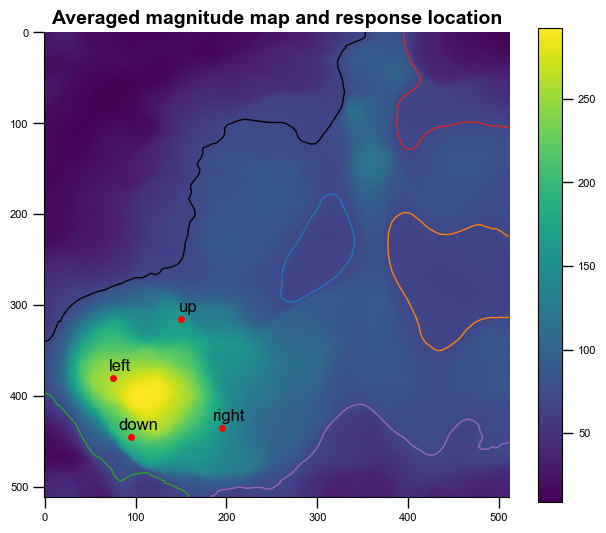

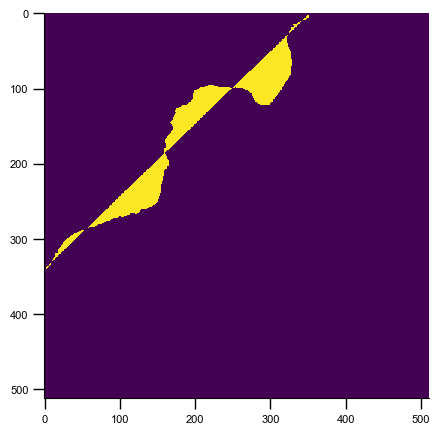

In [18]:

mag_contours = measure.find_contours(image=mag_f, level=70)
print('The number of contours is:', len(mag_contours))
fig, ax = plt.subplots(figsize=(7.5, 7.5))
camp = ax.imshow(mag_f)
for contour in mag_contours:
    if len(contour) > 100:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1)

ax.plot(down_xy[0], down_xy[1], 'ro')
ax.annotate('down', down_xy, textcoords='offset points', xytext=(5, 5), ha='center')
ax.plot(up_xy[0], up_xy[1], 'ro')
ax.annotate('up', up_xy, textcoords='offset points', xytext=(5, 5), ha='center')
ax.plot(left_xy[0], left_xy[1], 'ro')
ax.annotate('left', left_xy, textcoords='offset points', xytext=(5, 5), ha='center')
ax.plot(right_xy[0], right_xy[1], 'ro')
ax.annotate('right', right_xy, textcoords='offset points', xytext=(5, 5), ha='center')
plt.colorbar(camp, shrink=0.8)
plt.title('Averaged magnitude map and response location')
# adujst the distance between the title and the figure
plt.subplots_adjust(top=0.9)

plt.show()

# create a mask for the contour
mask = np.zeros_like(mag_f)
for contour in [mag_contours[0]]:
    if len(contour) > 100:
        mask += measure.grid_points_in_poly(shape=mask.shape, verts=contour).astype(int)
mask = mask.astype(bool)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(mask)
plt.show()

In [19]:
phase_el_f = median_filter(phase_el, size=33)
phase_az_f = median_filter(phase_az, size=33)


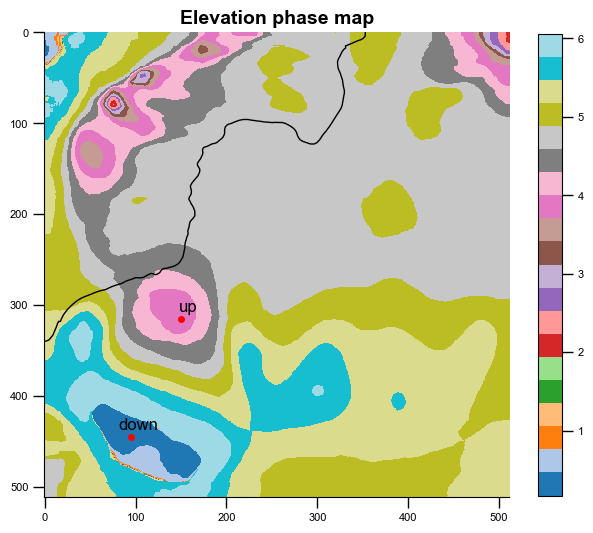

0.3248246383102833 3.9213512505822417
-3.5965266122719584


In [20]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
cmap = ax.imshow(phase_el_f, cmap='tab20')
ax.plot(down_xy[0], down_xy[1], 'ro')
ax.annotate('down', down_xy, textcoords='offset points', xytext=(5, 5), ha='center')
plt.plot(up_xy[0], up_xy[1], 'ro')
plt.annotate('up', up_xy, textcoords='offset points', xytext=(5, 5), ha='center')
plt.plot(mag_contours[0][:, 1], mag_contours[0][:, 0], linewidth=1)
plt.colorbar(cmap, shrink=0.8)
plt.title('Elevation phase map')
plt.show()

phase_down = phase_el_f[down_xy[1], down_xy[0]]
phase_up = phase_el_f[up_xy[1], up_xy[0]]
print(phase_down, phase_up)
phase_diff_el = phase_down - phase_up
print(phase_diff_el)

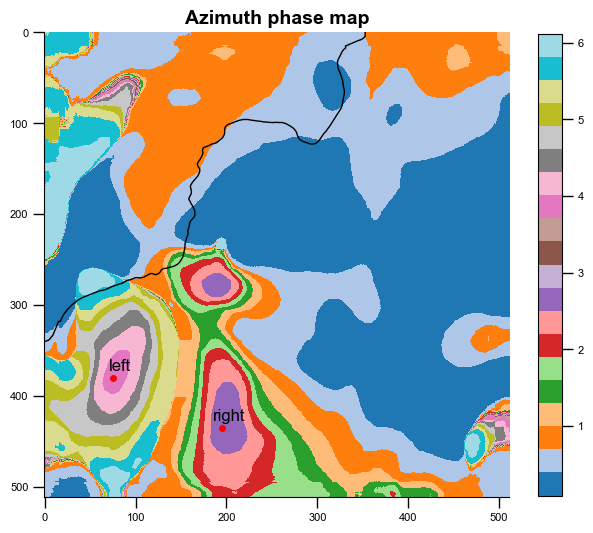

3.9193989890130942 2.736011197666839
-1.1833877913462554


In [21]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
cmap = ax.imshow(phase_az_f, cmap='tab20')
ax.plot(left_xy[0], left_xy[1], 'ro')
ax.annotate('left', left_xy, textcoords='offset points', xytext=(5, 5), ha='center')
ax.plot(right_xy[0], right_xy[1], 'ro')
ax.annotate('right', right_xy, textcoords='offset points', xytext=(5, 5), ha='center')
plt.plot(mag_contours[0][:, 1], mag_contours[0][:, 0], linewidth=1)
plt.colorbar(cmap, shrink=0.8)
plt.title('Azimuth phase map')
plt.show()


phase_left = phase_az_f[left_xy[1], left_xy[0]]
phase_right = phase_az_f[right_xy[1], right_xy[0]]
print(phase_left, phase_right)

phase_diff_az = phase_right - phase_left
print(phase_diff_az)

In [22]:
screen_width = 595 # in mm, the width of the screen
screen_height = 335 # in mm
distance = 180 # in mm
visual_center = (45, 10) # in degree
degree_left = visual_center[0] - np.rad2deg(np.arctan(screen_width/2/distance))
degree_right = visual_center[0] + np.rad2deg(np.arctan(screen_width/2/distance))
degree_up = visual_center[1] + np.rad2deg(np.arctan(screen_height/2/distance))
degree_down = visual_center[1] - np.rad2deg(np.arctan(screen_height/2/distance))
print(degree_left, degree_right, degree_up, degree_down)
print(phase_diff_az, phase_diff_el)
print(screen_width, screen_height)
print((degree_right - degree_left), (degree_up - degree_down))
scale_az = (degree_right - degree_left) / phase_diff_az
print(scale_az)
scale_el = (degree_up - degree_down) / phase_diff_el
print(scale_el)

-13.824299504261404 103.8242995042614 52.939888976276876 -32.939888976276876
-1.1833877913462554 -3.5965266122719584
595 335
117.64859900852281 85.87977795255375
-99.4167760296753
-23.878532598512518


In [ ]:
def get_contour(map, level_range, step, mask=None):
    contours = []
    for level in np.arange(level_range[0], level_range[1], step):
        contour = measure.find_contours(image=map, level=level, mask=mask)
        # Each contour is a ndarray of (row, column) coordinates along the contour.
        # Change the coordinates to (column, row)
        for i in range(len(contour)):
            contour[i] = np.flip(contour[i], axis=1)
        contours.extend(contour)
    return contours

In [ ]:


contours = get_contour(mag_f, [50, 200], 10, mask)

# plot the contours on the magnitude map, with the same color for the same level of contour
fig, ax = plt.subplots(figsize=(7.5, 7.5))
camp = ax.imshow(mag_f)
n_contours = len(contours)
colors = plt.cm.jet(np.linspace(0,1,n_contours))
for i, contour in enumerate(contours):
    if len(contour) > 30:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color=colors[i])
        # ax.contour(contour, levels=[50], colors='red', linewidths=1)
plt.colorbar(camp, shrink=0.8)
plt.title('Averaged magnitude map and response location')
plt.show()

In [ ]:
degree_el = phase_el_f*scale_el - phase_up*scale_el + degree_down
contours_el = get_contour(degree_el, [degree_down, degree_up], step=5, mask=mask)
plt.imshow(degree_el, cmap='tab20')
plt.plot(up_xy[0], up_xy[1], 'ro')
plt.plot(down_xy[0], down_xy[1], 'ro')
plt.colorbar()
plt.show()

In [ ]:
degree_az = phase_az_f*scale_az - phase_left*scale_az + degree_left
contours_az = get_contour(degree_az, [degree_left, degree_right], step=5, mask=mask)
plt.imshow(degree_az, cmap='tab20')
plt.plot(left_xy[0], left_xy[1], 'ro')
plt.plot(right_xy[0], right_xy[1], 'ro')
for contour in contours_az:
    plt.plot(contour[:, 0], contour[:, 1], linewidth=1)
plt.colorbar()
plt.show()

In [ ]:
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(figsize=(7.5, 7.5))
# camp = ax.imshow(phase_el_f) # cmap='tab20'
ax.imshow(sign_map, cmap='RdBu_r', clim=[-1, 1])
# ax.plot(mag_contours[0][:, 1], mag_contours[0][:, 0], linewidth=1)

# create a LineCollection with the contours and jet color mapping
line_collection = LineCollection(segments=contours_el, cmap='jet', array=np.arange(degree_down, degree_up, step=5), linewidths=1)
ax.add_collection(line_collection)
fig.colorbar(line_collection, shrink=0.8, label='Elevation degree')
# plt.colorbar(camp, shrink=0.8)
plt.title('Elevation contour plots')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
camp = ax.imshow(sign_map, cmap='RdBu_r', clim=[-1, 1])
# cmap = ax.imshow(phase_az_f)

line_collection = LineCollection(segments=contours_az, cmap='jet', array=np.arange(degree_left, degree_right, step=5), linewidths=1)
ax.add_collection(line_collection)
fig.colorbar(line_collection, shrink=0.8, label='Azimuth degree')
# plt.colorbar(camp, shrink=0.8)
plt.title('Azimuth contour plots')
plt.show()